In [1]:
%matplotlib inline
import pandas as pd
import numpy as np 
import seaborn as sn
import codecs
import statsmodels as st
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy as sc
from scipy import stats
from patsy import dmatrices
import matplotlib as mt
from scipy import stats
from statsmodels.formula.api import logit, probit, poisson, ols
from statsmodels import stats
import sklearn as sk
from sklearn.linear_model import LogisticRegression


# Logistic function


Shown in the plot is how the logistic regression would, in this
synthetic dataset, classify values as either 0 or 1,
i.e. class one or two, using the logistic curve.




In [2]:
%matplotlib inline

In [3]:
mt.style.use('seaborn-paper')

##ustawienie czcionki 
font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)



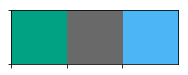

In [4]:
# setting palette
pal = ["#01A183", "#696969", "#4Cb5F5"]
sn.palplot(sn.color_palette(pal))

In [5]:
#all = pd.read_excel("C:\\Users\\swidrak\\OneDrive\\python\\ultimatum2\\data\\allupdated.xlsx")
all = pd.read_excel("C:\\Users\\Justyna\\Python Scripts\\ultimatum2\\data\\ultimatum2.xlsx")

In [6]:
all = all[all["cut"] == "keep"]
all = all[all["cut2"] == "keep"]

In [7]:
#new columns
all.loc[:,'name'] = all.loc[:,'agent'].apply(lambda x: "low status" if x == 0 else "high status")

all['touch'] = all.loc[:,('touch')].apply(lambda x: 0 if x == 0.0 else 1)

all['cult'] = all.loc[:,('country')].apply(lambda x: 1 if x == "pl" else 0)

all['offerParC'] = all.loc[:,'offerPar'].apply(lambda x: "unfair" if x < 36 else ("fair" if x > 36 and x < 46 else "generous"))

In [8]:
pro = all[all["parPro"] == 1]
res = all[all["parPro"] == 0]

pl = all[all["country"] == "pl"]
ca = all[all["country"] == "cat"]

plpro = pl[pl["parPro"] == 1]
capro = ca[ca["parPro"] == 1]

plres = pl[pl["parPro"] == 0]
cares = ca[ca["parPro"] == 0]

# CALCULATIONS

## participant responder

In [9]:
#acceptance rate by country and category
res.groupby(["offerParC", "name", "country"])["accepted"].mean()*100

offerParC  name         country
fair       high status  cat         44.444444
                        pl          46.666667
           low status   cat         32.098765
                        pl          33.333333
generous   high status  cat         88.888889
                        pl          76.000000
           low status   cat        100.000000
                        pl          84.000000
unfair     high status  cat          7.407407
                        pl          16.000000
           low status   cat          9.259259
                        pl          12.000000
Name: accepted, dtype: float64

In [10]:
inf = logit("accepted ~  agent*touch + cult + Zstat + Zatg + Zmras", res).fit()
#workaround of the error "AttributeError: module 'scipy.stats' has no attribute 'chisqprob'"

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

print(inf.summary())
print(inf.wald_test_terms())

Optimization terminated successfully.
         Current function value: 0.623291
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               accepted   No. Observations:                  624
Model:                          Logit   Df Residuals:                      616
Method:                           MLE   Df Model:                            7
Date:                Mon, 27 Aug 2018   Pseudo R-squ.:                 0.06015
Time:                        10:10:47   Log-Likelihood:                -388.93
converged:                       True   LL-Null:                       -413.82
                                        LLR p-value:                 1.595e-08
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.1919      0.222     -5.372      0.000      -1.627      -0.757
agent           0.5928    

In [11]:
#POLAND

inf = logit("accepted ~  agent*touch + Zstat + Zatg + Zmras", plres).fit()
#workaround of the error "AttributeError: module 'scipy.stats' has no attribute 'chisqprob'"

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

print(inf.summary())
print(inf.wald_test_terms())

Optimization terminated successfully.
         Current function value: 0.598626
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               accepted   No. Observations:                  300
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            6
Date:                Mon, 27 Aug 2018   Pseudo R-squ.:                 0.09854
Time:                        10:10:47   Log-Likelihood:                -179.59
converged:                       True   LL-Null:                       -199.22
                                        LLR p-value:                 6.356e-07
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.7773      0.324     -5.491      0.000      -2.412      -1.143
agent           0.8674    

In [12]:
# CATALONIA

inf = logit("accepted ~  agent*touch + Zstat + Zatg + Zmras", cares).fit()
#workaround of the error "AttributeError: module 'scipy.stats' has no attribute 'chisqprob'"

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

print(inf.summary())
print(inf.wald_test_terms())

Optimization terminated successfully.
         Current function value: 0.620339
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               accepted   No. Observations:                  324
Model:                          Logit   Df Residuals:                      317
Method:                           MLE   Df Model:                            6
Date:                Mon, 27 Aug 2018   Pseudo R-squ.:                 0.06342
Time:                        10:10:47   Log-Likelihood:                -200.99
converged:                       True   LL-Null:                       -214.60
                                        LLR p-value:                 0.0001317
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.5142      0.311     -4.865      0.000      -2.124      -0.904
agent           0.3802    

## participant proposer

In [13]:
#cutting into categories (into defined number of even categories or with defined bins)

bins = pd.IntervalIndex.from_tuples(((0,10), (10,20), (20,30), (30,40), 
                                     (40,50), (50,60), (60,70), (70,80),
                                    (80,90), (90,100)))

pro.loc[:,"offerAgC"] = pd.cut(x = pro.loc[:,"offerAg"], bins = bins, labels = False)

#pro.loc[:,("offerAgC", "offerAg")]

C:\Users\Justyna\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Justyna\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
#pro["prevParPro"]

In [15]:
# mean value of offers for agents by country
pro[pro["prevParPro"] == 0].groupby(["name", "country"])["offerAg"].describe()

count       mean        std   min   25%   50%   75%   max
name        country                                                           
high status cat       54.0  44.240741  10.013077   3.0  40.0  46.5  50.0  65.0
            pl        50.0  44.140000  11.596991   1.0  40.0  45.0  50.0  90.0
low status  cat       68.0  46.132353   7.845342  30.0  42.0  47.0  50.0  85.0
            pl        63.0  43.190476   7.772692  10.0  40.0  45.0  50.0  55.0

In [16]:
pro[["offerAg", "Zatg", "Zstat", "Zemb", "ZsocPres"]].corr(method="pearson")

,offerAg,Zatg,Zstat,Zemb,ZsocPres
offerAg,1.000000,0.061513,-0.063265,0.273629,0.004604
Zatg,0.061513,1.000000,0.107921,-0.217639,0.005474
Zstat,-0.063265,0.107921,1.000000,-0.132519,0.146949
Zemb,0.273629,-0.217639,-0.132519,1.000000,0.046482
ZsocPres,0.004604,0.005474,0.146949,0.046482,1.000000


In [17]:
plpro[["offerAg", "Zatg", "Zstat", "Zemb", "ZsocPres"]].corr(method="pearson")

,offerAg,Zatg,Zstat,Zemb,ZsocPres
offerAg,1.000000,0.250950,-0.270297,0.313549,-0.182992
Zatg,0.250950,1.000000,-0.013286,-0.064360,0.170115
Zstat,-0.270297,-0.013286,1.000000,0.031793,0.388702
Zemb,0.313549,-0.064360,0.031793,1.000000,-0.393528
ZsocPres,-0.182992,0.170115,0.388702,-0.393528,1.000000


In [18]:
capro[["offerAg", "Zatg", "Zstat", "Zemb", "ZsocPres"]].corr(method="pearson")

,offerAg,Zatg,Zstat,Zemb,ZsocPres
offerAg,1.000000,-0.046119,0.134043,0.191754,0.186778
Zatg,-0.046119,1.000000,0.137104,-0.166484,-0.067831
Zstat,0.134043,0.137104,1.000000,-0.246782,-0.015691
Zemb,0.191754,-0.166484,-0.246782,1.000000,0.521823
ZsocPres,0.186778,-0.067831,-0.015691,0.521823,1.000000


In [19]:
print("atg: ", sc.stats.spearmanr(pro.offerAg,pro.Zatg))
print("stat: ", sc.stats.spearmanr(pro.offerAg,pro.Zstat)) 
print("socPres: ", sc.stats.spearmanr(pro.offerAg,pro.ZsocPres)) 
print("emb: ", sc.stats.spearmanr(pro.offerAg,pro.Zemb)) 

atg:  SpearmanrResult(correlation=0.02157542769928245, pvalue=0.7291493145839301)
stat:  SpearmanrResult(correlation=-0.1142023151285292, pvalue=0.06597346117145136)
socPres:  SpearmanrResult(correlation=0.11454929418607773, pvalue=0.06515004286419583)
emb:  SpearmanrResult(correlation=0.21190935187909804, pvalue=0.0005825379286159126)


In [20]:
print("atg: ", sc.stats.spearmanr(plpro.offerAg, plpro.Zatg))
print("stat: ", sc.stats.spearmanr(plpro.offerAg, plpro.Zstat)) 
print("socPres: ", sc.stats.spearmanr(plpro.offerAg, plpro.ZsocPres)) 
print("emb: ", sc.stats.spearmanr(plpro.offerAg, plpro.Zemb))

atg:  SpearmanrResult(correlation=0.23686471973021758, pvalue=0.007823766309932331)
stat:  SpearmanrResult(correlation=-0.29323807986037176, pvalue=0.0009039344691942118)
socPres:  SpearmanrResult(correlation=0.014741820640568119, pvalue=0.8703833212381769)
emb:  SpearmanrResult(correlation=0.22290204601839606, pvalue=0.012468378703714178)


In [21]:
print("atg: ", sc.stats.spearmanr(capro.offerAg, capro.Zatg))
print("stat: ", sc.stats.spearmanr(capro.offerAg, capro.Zstat)) 
print("socPres: ", sc.stats.spearmanr(capro.offerAg, capro.ZsocPres)) 
print("emb: ", sc.stats.spearmanr(capro.offerAg, capro.Zemb))

atg:  SpearmanrResult(correlation=0.0063342624856080765, pvalue=0.9418746899518413)
stat:  SpearmanrResult(correlation=0.05757391930871573, pvalue=0.5071522234585172)
socPres:  SpearmanrResult(correlation=0.19077842335788223, pvalue=0.026661992700200716)
emb:  SpearmanrResult(correlation=0.21227277731731947, pvalue=0.013447682066392207)


In [22]:
formula = ' offerAg ~  agent * cult * prevTouch * Zstat'
result = smf.ols(formula, data = pro).fit()

print(result.summary())
print(result.wald_test_terms()) 

                            OLS Regression Results                            
Dep. Variable:                offerAg   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.232
Date:                Mon, 27 Aug 2018   Prob (F-statistic):              0.249
Time:                        10:10:49   Log-Likelihood:                -846.52
No. Observations:                 235   AIC:                             1725.
Df Residuals:                     219   BIC:                             1780.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

# PLOTS

# seaborn.regplot

In [23]:
mt.style.use('seaborn-paper')

##ustawienie czcionki 
font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)


seaborn.regplot(x, y, data=None, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=False, dropna=True, x_jitter=None, y_jitter=None, label=None, color=None, marker='o', scatter_kws=None, line_kws=None, ax=None)

In [24]:
#sn.regplot(x = "touch", y = "accepted", data = res, scatter = True, logistic = True)

In [25]:
# plot residuals
#sn.residplot(x = "touch", y = "accepted", data = res)

# seaborn.lmplot
seaborn.lmplot(x, y, data, hue=None, col=None, row=None, palette=None, col_wrap=None, height=5, aspect=1, markers='o', sharex=True, sharey=True, hue_order=None, col_order=None, row_order=None, legend=True, legend_out=True, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=False, x_jitter=None, y_jitter=None, scatter_kws=None, line_kws=None, size=None)

Plot data and regression model fits across a FacetGrid.

This function combines regplot() and FacetGrid. It is intended as a convenient interface to fit regression models across conditional subsets of a dataset.

C:\Users\Justyna\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


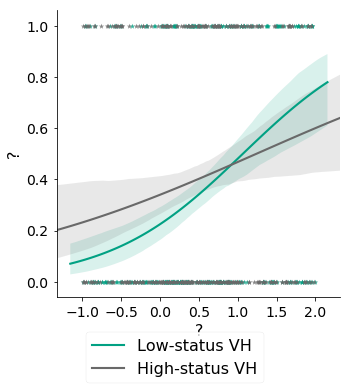

In [26]:
g = (sn.lmplot(x = "touch", 
               y = "accepted", 
               hue = "agent", 
               data = res, 
               fit_reg = True, 
               logistic = True,
               #row = "country", row - plots vertically, col plots horizontally 
               #sharex = True,
               #sharey = True,
               scatter = True, 
               markers = "*",
               legend=False,
               palette = pal,
               y_jitter = False, 
               x_jitter = True)).set_axis_labels("", "Acceptance rate of VH's offer")

plt.legend(('Low-status VH', 'High-status VH'), fontsize=16, loc=[.1,-.3])

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel("?", fontsize=16)
plt.ylabel("?", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

g.savefig('logRegression.png', transparent=True, figsize=(8,6))

C:\Users\Justyna\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 720x432 with 0 Axes>

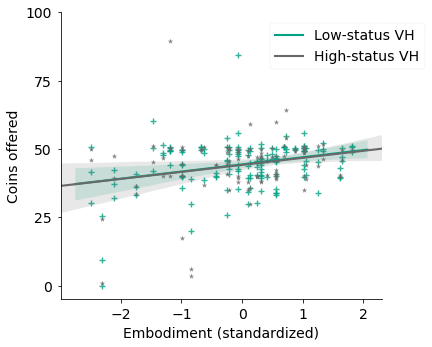

In [27]:
plt.figure(figsize=(10,6), frameon=False)

g = sn.lmplot(x = "Zemb", 
          y = "offerAg", 
          hue = "agent", 
          #col = "country", 
          data = pro, 
          sharex = True,
          sharey = True,
          legend_out=True,
          legend = False,
          scatter = True, 
          fit_reg = True, 
          logistic = False, 
          markers=["+", "*"],
          palette = pal,
          y_jitter = True,
          aspect=1.1) 

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Embodiment (standardized)', fontsize=14)
plt.ylabel('Coins offered', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([0, 25, 50, 75,100], fontsize=14)

#legend
plt.legend(('Low-status VH', 'High-status VH'), 
           loc=[0.65, 0.8], fontsize=14)

#g.savefig('linearReg.png', transparent=True, figsize=(9,7))

C:\Users\Justyna\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 648x432 with 0 Axes>

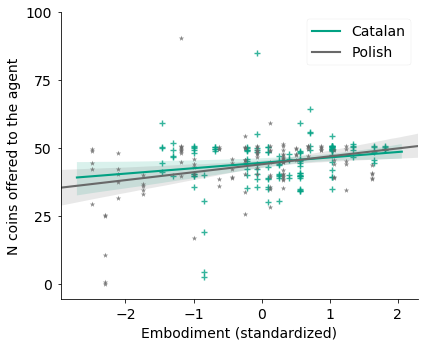

In [28]:
plt.figure(figsize=(9,6), frameon=False)

g = sn.lmplot(x = "Zemb", 
          y = "offerAg", 
          hue = "country", 
          data = pro, 
          sharex = True,
          sharey = True,
          legend_out=True,
          legend = False,
          scatter = True, 
          fit_reg = True, 
          logistic = False, 
          markers=["+", "*"],
          palette = pal,
          y_jitter = True,
          aspect=1.2) 

    
    
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Embodiment (standardized)', fontsize=14)
plt.ylabel('N coins offered to the agent', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([0, 25, 50, 75,100], fontsize=14)

#legend
plt.legend(["Catalan", "Polish"], loc="best", fontsize=14)

#g.savefig('linearReg.png', transparent=True, figsize=(9,6), dpi = 300)

# Pallettes for plotting:
    
Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

https://matplotlib.org/users/colormaps.html

In [1]:
#sn.lmplot?

C:\Users\Justyna\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


([<matplotlib.axis.YTick at 0x8ef2d135c0>,
 <a list of 5 Text yticklabel objects>)

<Figure size 648x432 with 0 Axes>

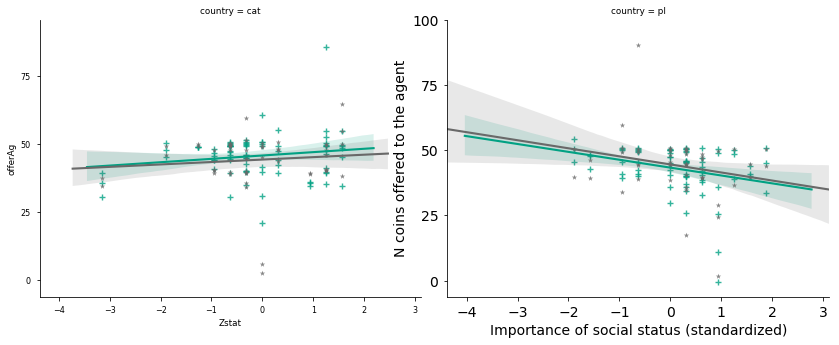

In [30]:
plt.figure(figsize=(9,6), frameon=False)

g = sn.lmplot(x = "Zstat", 
          y = "offerAg", 
          col = "country", 
          hue= "agent",
          data = pro, 
          sharex = True,
          sharey = True,
          legend_out=True,
          legend = False,
          scatter = True, 
          fit_reg = True, 
          logistic = False, 
          markers=["+", "*"],
          palette = pal,
          y_jitter = True,
          aspect=1.2)

    
    
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('Importance of social status (standardized)', fontsize=14)
plt.ylabel('N coins offered to the agent', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([0, 25, 50, 75,100], fontsize=14)

#legend
#plt.legend(["Catalan", "Polish"], loc="best", fontsize=14)

#g.savefig('linearReg.png', transparent=True, figsize=(9,6), dpi = 300)